In [89]:
import matplotlib.pyplot as plt
import numpy as np 

# Utility functions
def plot_weights(w_D, v_G):
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    plt.plot(np.arange(np.shape(w_D)[0]), w_D, label="discriminator")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(np.arange(np.shape(w_D)[0]), v_G, label="generator")
    plt.legend()
    plt.show()
    
    print("Recovered mean from generator: {}"
          .format(np.mean(v_G, axis=0)))
    print("Last mean from generator: {}".format(v_G[-1]))

# Learning the Mean of  Multi-Variate Gaussians with a Linear WGAN

We consider the following very simple GAN example: The data are generated by a multivariate normal distribution of the form: for some $v\in \mathbb{R}^d$:
\begin{equation}
x \sim N({\bf v}, I)
\end{equation}

We consider a WGAN, where the discriminator is a linear function based on a parameter $w \in \mathbb{R}^d$, which takes as input a data point $x$ and outputs the inner product with $w$, i.e.: 
\begin{equation}
D(x; w) = \langle w, x \rangle
\end{equation}
The generator is another linear function based on a parameter $\theta\in \mathbb{R}^d$, which takes as input a random noise vector $z\sim N(0, I)$ in $\mathbb{R}^d$ and outputs the displaced random vector $z + \theta$, i.e.:
\begin{equation}
G(z; \theta) = z + \theta
\end{equation}
The goal of the generator is to figure out the true distribution, i.e. to converge to $\theta = v$ for the true $v$.

The WGAN loss is based on the intution that the space of functions of the discriminator will be large enough that they will approximate the Wasserstein metric between the true distribution and the distribution produced by the generator. 
\begin{equation}
\sup_{w} \mathbb{E}_{x\sim N(v, I)}\left[ D(x; w) \right] - \mathbb{E}_{z\sim N(0,I)}\left[D(G(z; \theta); w)\right]
\end{equation}
For the specific class of discriminator functions that we are using the latter boils down to:
\begin{equation}
\sup_{w} \mathbb{E}_{x\sim N(v, I)}\left[ \langle w, x \rangle \right] - \mathbb{E}_{z\sim N(0,I)}\left[\langle w, z + \theta \rangle\right] 
\end{equation}

The generator is trying to minimize the latter metric, which leads to the following zero-sum game:
\begin{equation}
\inf_{\theta} \sup_{w} \mathbb{E}_{x\sim N(v, I)}\left[ \langle w, x \rangle \right] - \mathbb{E}_{z\sim N(0,I)}\left[\langle w, z + \theta \rangle\right] 
\end{equation}



In [90]:
# Parameters of distribution
dim = 2
v = [3, 4]

## Simulations without Sampling Noise

We first consider the case where we optimize the true expectations above rather than assuming that we only get samples of $x$ and samples of $z$. In this case the expected zero-sum game takes the following very simple form:
\begin{equation}
\inf_{\theta} \sup_{w}   \langle w, v-\theta \rangle
\end{equation}

We see here that one equilibrium for the above game is for the generator to choose $\theta=v$ and for the discriminator to choose $w = 0$.

We will simulate simultaneous training in this zero-sum game under the GD and under Optimistic GD and we will examine convergence of the dynamics to this equilibrium. We will see that SGD does not converge to an equilibrium and only the running average of the solutions is an equilibrium, while optimistic SGD converges to an equilibrium pointwise. In the next section we will also incorporate sampling errors and look at stochastic gradient descent and its optimistic variant.

For this simple zero sum game the GD dynamics take the simple form:
\begin{align}
w_{t+1} =& w_{t} + \eta_D (v - \theta_{t})\\
\theta_{t+1} =& \theta_{t} + \eta_G w_t
\end{align}
while the optimistic GD dynamics take the form:
\begin{align}
w_{t+1} =& w_{t} + 2\eta_D (v - \theta_{t}) - \eta_D (v-\theta_{t-1})\\
\theta_{t+1} =& \theta_{t} + 2\eta_G w_t - \eta_G w_{t-1} 
\end{align}

To help GD not cycle, we also employ standard approaches in WGAN training:
- Weight clipping: we cap the weights to not go outside the range [-H, H], to ensure the discriminator represents a Lipschitz function
- Asymmetric training: we train the generator multiple times in between one training step of the generator

We observe that GD training cycles even after this standard modifications in WGAN training. On the other hand, optimistic GD does not cycle even if we don't utilize these modifications.

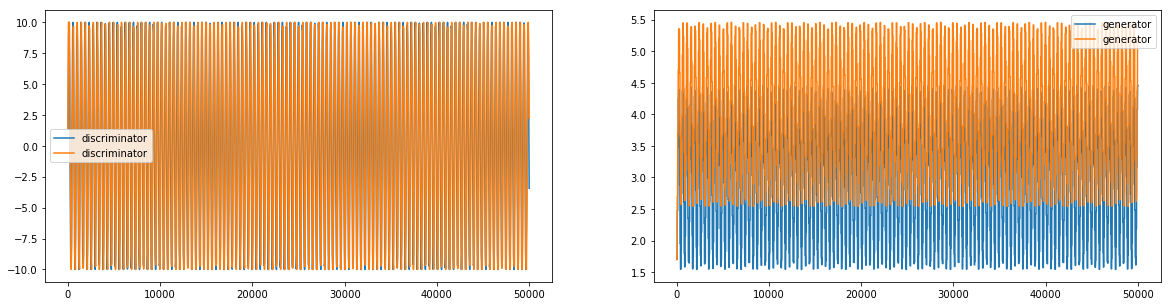

Recovered mean from generator: [ 3.00097031  3.9977335 ]
Last mean from generator: [ 4.45716625  5.19417956]


In [106]:
# GD with Clipping on the expected loss
T = 50000
clip_D = 10
clip_G = 10
eta_D = .1
eta_G = .1
train_gen_every = 50
w = 1.4*np.ones((T, dim))
theta = 1.7*np.ones((T, dim))

for t in range(1,T):
    w[t] = np.clip(w[t-1] + eta_D * (v - theta[t-1]), 
                   -clip_D, clip_D)
    if t % train_gen_every == 0:
        theta[t] = np.clip(theta[t-1] + eta_G * (w[t-1]), 
                       -clip_G, clip_G)
    else:
        theta[t] = theta[t-1]

plot_weights(w, theta)

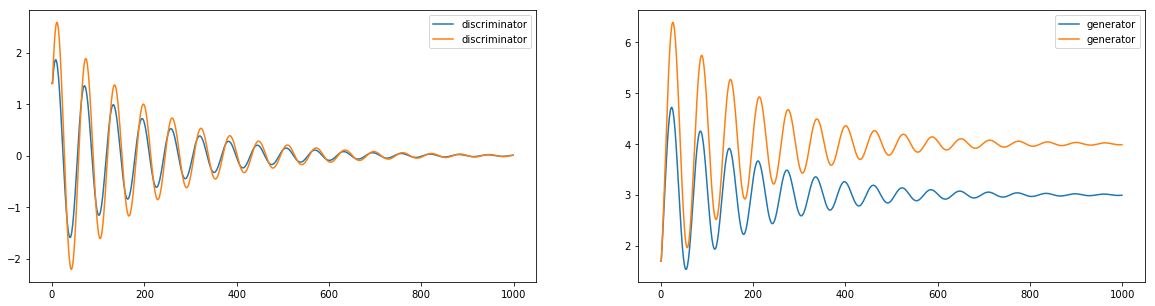

Recovered mean from generator: [ 3.01131623  4.00931959]
Last mean from generator: [ 2.99125639  3.98489638]


In [92]:
# Optimistic GD Training on the expected loss
T = 1000
eta_D = .1
eta_G = .1
w = 1.4*np.ones((T, dim))
theta = 1.7*np.ones((T, dim))

for t in range(2,T):
    w[t] = w[t-1] + 2 * eta_D * (v-theta[t-1]) - eta_D * (v-theta[t-2])
    theta[t] = theta[t-1] + 2 * eta_G * w[t-1] - eta_G * w[t-2]

plot_weights(w, theta)

### GD with Gradient Penalty

We also analyze the technique of the paper https://arxiv.org/pdf/1704.00028.pdf where a gradient penalty is introduced to the GD algorithm. In particular the WGAN loss is modified to put a "ridge-like" penalty on the weights of the discriminator. This ensures that the discriminator weights stay small enough and hence the function $D(x; w)$ is a Lipschitz function. 

In particular the paper proposes that we alter the WGAN loss as follows:
\begin{equation}
L(w,\theta) = \mathbb{E}_{x\sim N(v, I)}\left[ D(x; w) \right] - \mathbb{E}_{z\sim N(0,I)}\left[D(G(z; \theta); w)\right] + \lambda \left(\left\|\mathbb{E}_{\hat{x} \sim F_{\epsilon}}\left[\nabla_x D(x; w)\right]\right\|_2 - 1\right)^2
\end{equation}
where the distribution $F_{\epsilon}$ is the distribution of a convex combination of a sample from the true distribution $N(v, I)$ and the distribution of the generator $N(\theta, I)$, with weight $\epsilon$ on the true distribution. The latter is simply a sample from the distribution $N(\epsilon v+(1-\epsilon)\theta, I)$.

In our setting, because the discriminator is linear in $x$, we have that the gradient in the penalty term is independent of $x$ and hence the distribution of $x$ is irrelevant:
\begin{equation}
\nabla_x D(x; w) = w
\end{equation}
Thus we get that for our setting the gradient penalty modified WGAN loss is:
\begin{equation}
L(w,\theta) = \mathbb{E}_{x\sim N(v, I)}\left[ D(x; w) \right] - \mathbb{E}_{z\sim N(0,I)}\left[D(G(z; \theta); w)\right] + \lambda \left(\left\|w\right\|_2 - 1\right)^2
\end{equation}

When training with no sampling noise, the latter simplifies to:
\begin{equation}
\inf_{\theta} \sup_{w}   \langle w, v-\theta \rangle + \lambda \left(\left\|w\right\|_2 - 1\right)^2
\end{equation}

The equilibrium where the generator chooses $\theta=v$ and the discriminator chooses $w = 0$ is still preserved. Under this gradient penalty, GD training is modified as:
\begin{align}
w_{t+1} =& w_{t} + \eta_D (v - \theta_{t}) + 2 \lambda w_{t} \frac{\|w_t\|_2 -1}{\|w_t\|_2}\\
\theta_{t+1} =& \theta_{t} + \eta_G w_t
\end{align}

We observe that the latter does not fix the cycling problem of GD

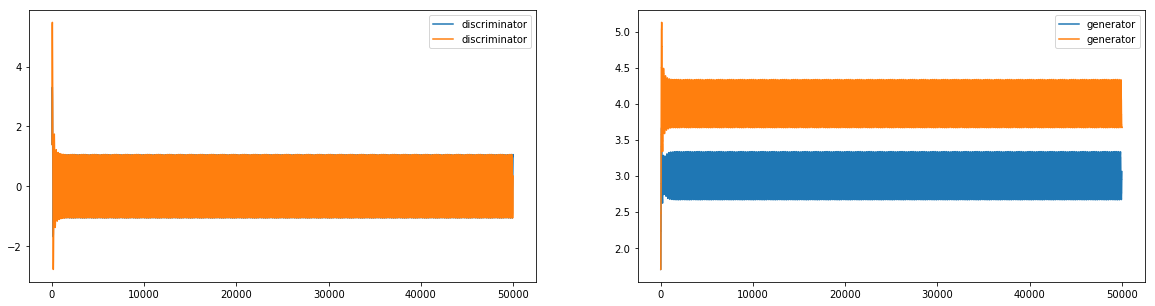

Recovered mean from generator: [ 2.99961064  3.99943105]
Last mean from generator: [ 3.0568171   3.67001276]


In [121]:
# GD With Gradient Penalty
T = 50000
clip_D = 10
clip_G = 10
eta_D = .1
eta_G = .1
lambda_D = .01
train_gen_every = 10
w = 1.4*np.ones((T, dim))
theta = 1.7*np.ones((T, dim))

for t in range(1,T):
    w[t] = w[t-1] + eta_D * (v-theta[t-1])\
            - 2*lambda_D*w[t-1]*(1.0 - 1.0/np.linalg.norm(w[t-1]))
    if t % train_gen_every == 0:
        theta[t] = theta[t-1] + eta_G * w[t-1]
    else:
        theta[t] = theta[t-1]

plot_weights(w, theta)

### GD with Haoyang's Gradient Penalty

Haoyang derived the following penalty gradient dynamics, which seem to be fixing the GD training by dampening it, but it doesn't seem to follow the penalty gradient recipe of https://arxiv.org/pdf/1704.00028.pdf. They are very interested dynamics, and seem to be similar in spirit with optimistic dynamics. 

\begin{align}
w_{t+1} =& w_{t} + \eta_D (v - \theta_{t})\\
\theta_{t+1} =& \theta_{t} + \eta_G w_t - 2\lambda \cdot |\theta_{t-1} - v -1| * sign(\theta_{t-1} - v)
\end{align}
where the absolute in the last term is a element-wise maximum of the vector, similarly $sign(\cdot)$ is element-wise sign and $*$ is an elementwise product.

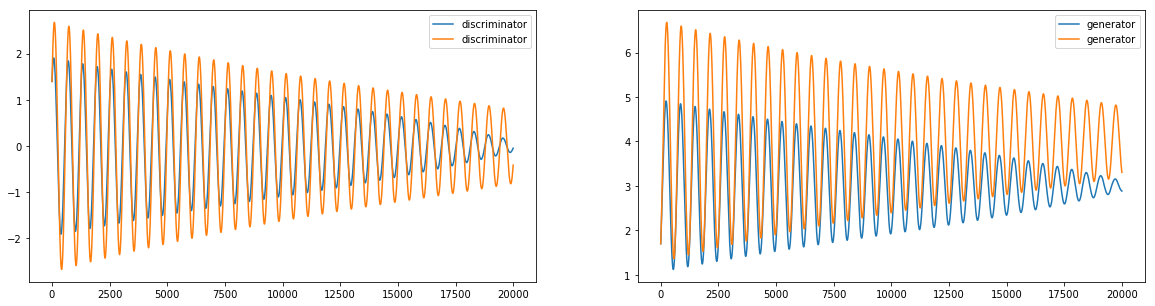

Recovered mean from generator: [ 3.007234    4.00904073]
Last mean from generator: [ 2.8845805   3.30649397]


In [95]:
# GD With Haoyang's Gradient Penalty
T = 20000
clip_D = 10
clip_G = 10
eta_D = .01
eta_G = .01
lambda_D = 0.0001
train_gen_every = 1
w = 1.4*np.ones((T, dim))
theta = 1.7*np.ones((T, dim))

for t in range(1,T):
    w[t] = np.clip(w[t-1] + eta_D * (v-theta[t-1]), -clip_D, clip_D)
    if t % train_gen_every == 0:
        theta[t] = theta[t-1] + eta_G * w[t-1]\
                    - 2*lambda_D*(np.abs(theta[t-1]-v-1)\
                                  *np.sign(theta[t-1]-v))  
    else:
        theta[t] = theta[t-1]

plot_weights(w, theta)

### GD with Momentum

We also analyze GD with momentum, based on Nesterov's accelerated gradient descent algorithm. GD with momentum when minimizing some arbitrary loss function $L(w)$ with respect to $w$ is defined as follows:
\begin{align}
m_{t} =& \gamma m_{t-1} + \eta \nabla_w L(w)\\
\theta_{t+1} =& \theta_t - m_t
\end{align}

Thus for our zero-sum game, the update rule for the discriminator is now:
\begin{align}
m_t^D =& \gamma_D m_{t-1}^D + \eta_D (v-\theta_{t})\\
w_{t+1} =& w_{t} + m_t^D
\end{align}
Similarly for the generator:
\begin{align}
m_t^G =& \gamma_G m_{t-1}^G - \eta_G w_t\\
\theta_{t+1} =& \theta_{t} - m_t^G 
\end{align}

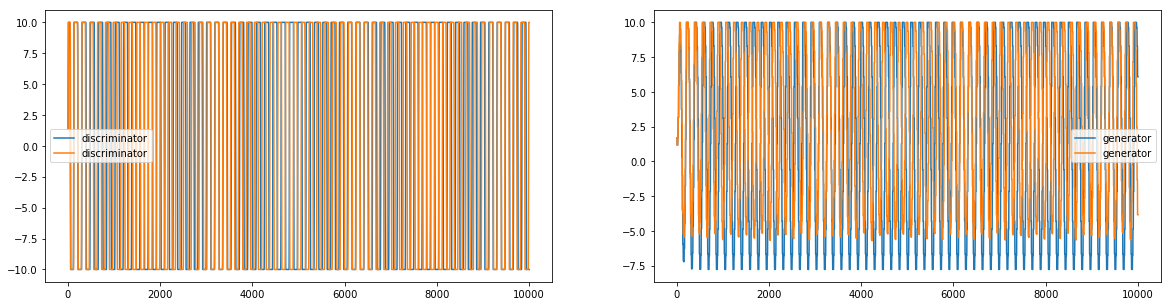

Recovered mean from generator: [ 1.86951918  3.08648819]
Last mean from generator: [ 6.08180848 -3.83630332]


In [115]:
# GD with Momentum
T = 10000
clip_D = 10
clip_G = 10
eta_D = .1
eta_G = .1
gamma_D = 0.9
gamma_G = 0.9
train_gen_every = 10
w = 1.4*np.ones((T, dim))
theta = 1.7*np.ones((T, dim))
m_D = 1.4*np.ones((T, dim))
m_G = 1.7*np.ones((T, dim))

for t in range(2,T):
    m_D[t-1] = gamma_D * m_D[t-2] + eta_D * (v - theta[t-1])
    w[t] = np.clip(w[t-1] + m_D[t-1], 
                   -clip_D, clip_D)
    if t % train_gen_every == 0:
        m_G[t-1] = gamma_G * m_G[t-2] - eta_G * (w[t-1]) 
        theta[t] = np.clip(theta[t-1] - m_G[t-1], 
                       -clip_G, clip_G)
    else:
        m_G[t-1] = m_G[t-2]
        theta[t] = theta[t-1]

plot_weights(w, theta)

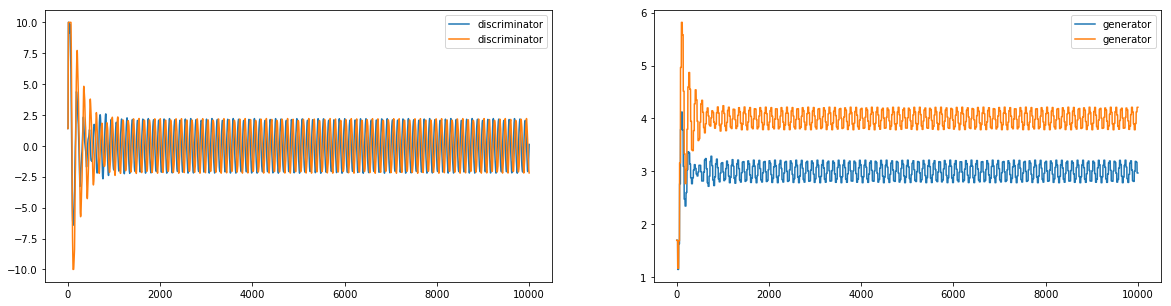

Recovered mean from generator: [ 2.99438575  3.9897201 ]
Last mean from generator: [ 2.97010157  4.21096818]


In [124]:
# GD with Momentum and Gradient Penalty
T = 10000
clip_D = 10
clip_G = 10
eta_D = .1
eta_G = .1
gamma_D = 0.9
gamma_G = 0.9
train_gen_every = 20
w = 1.4*np.ones((T, dim))
theta = 1.7*np.ones((T, dim))
m_D = 1.4*np.ones((T, dim))
m_G = 1.7*np.ones((T, dim))

for t in range(2,T):
    m_D[t-1] = gamma_D * m_D[t-2] + eta_D * (v - theta[t-1]) - 2*lambda_D*w[t-1]*(1.0 - 1.0/np.linalg.norm(w[t-1]))
    w[t] = np.clip(w[t-1] + m_D[t-1], 
                   -clip_D, clip_D)
    if t % train_gen_every == 0:
        m_G[t-1] = gamma_G * m_G[t-2] - eta_G * (w[t-1]) 
        theta[t] = np.clip(theta[t-1] - m_G[t-1], 
                       -clip_G, clip_G)
    else:
        m_G[t-1] = m_G[t-2]
        theta[t] = theta[t-1]

plot_weights(w, theta)

## With Sampling Noise

In the case of sampling noise, we assume that we have a set of real samples $x_1,\ldots, x_N$ and a set of noise samples $z_1,\ldots, z_N$ and we are trying to minimize the empirical WGAN loss:
\begin{equation}
\inf_{\theta} \sup_{w} \frac{1}{N} \sum_{i=1}^N \langle w, x_i \rangle - \frac{1}{n} \sum_{i=1}^N  \langle w, z_i + \theta \rangle 
\end{equation}
Equivalently this simplifies to:
\begin{equation}
\inf_{\theta} \sup_{w} \frac{1}{N} \sum_{i=1}^N \langle w, x_i - z_i - \theta \rangle 
\end{equation}

We will train the generator and discriminator via stochastic gradient descent, i.e. at every time using only a single sample of $x_i$ and a single sample of $z_i$ to approximate the gradient of the latter emprical loss. This leads to the following training scheme:
\begin{align}
w_{t+1} =& w_{t} + \eta_D (x_t - z_t - \theta_{t})\\
\theta_{t+1} =& \theta_{t} + \eta_G w_t
\end{align}
Similarly optimistic stochastic GD dynamics take the form:
\begin{align}
w_{t+1} =& w_{t} + 2\eta_D (x_t - z_t - \theta_t) - \eta_D (x_{t-1} - z_{t-1} - \theta_{t-1})\\
\theta_{t+1} =& \theta_{t} + 2\eta_G w_t - \eta_G w_{t-1} 
\end{align}

To avoid the huge sampling variance, which is contrary to the stability that optimistic gradient decent requires, we will also use a large mini-batch size at each training iteration, i.e. we use averages of a small minibatch of $x_i$ and $z_i$. We test the quality of convergence as a function of the size of the mini-batch.


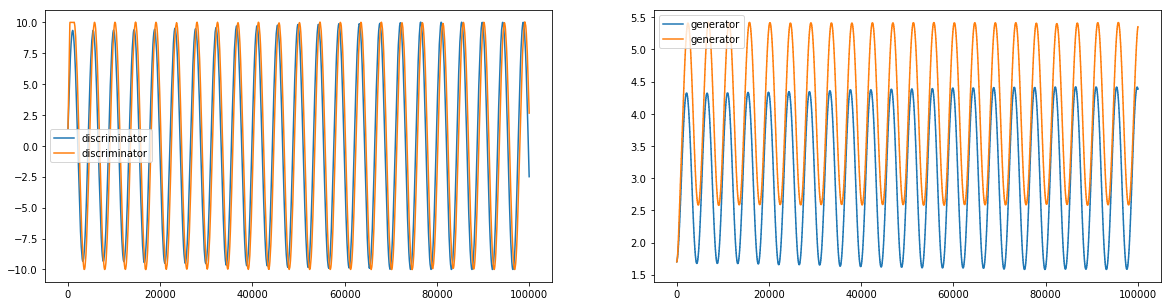

Recovered mean from generator: [ 3.00370758  3.99004014]
Last mean from generator: [ 4.38179221  5.35333329]


In [74]:
# SGD Training on Sampled Loss with minibatching
T = 100000
minibatch = 200
clip_D = 10
clip_G = 10
eta_D = .01
eta_G = .01
train_gen_every = 50

# Initialize weights and sample
w = 1.4*np.ones((T, dim))
theta = 1.7*np.ones((T, dim))
xs = np.random.multivariate_normal(mean=v, 
                                   cov = np.eye(dim), 
                                   size=(T, minibatch))
zs = np.random.multivariate_normal(mean=np.zeros(dim),
                                   cov = np.eye(dim),
                                   size=(T, minibatch))

# Compute average of minibatches
bxs = np.mean(xs, axis=1)
bzs = np.mean(zs, axis=1)

for t in range(1,T):
    w[t] = np.clip(w[t-1] + eta_D * (bxs[t-1] - bzs[t-1] - theta[t-1]),
                     -clip_D, clip_D)
    if t % train_gen_every == 0:
        theta[t] = np.clip(theta[t-1] + eta_G * (w[t-1]),
                           -clip_G, clip_G)
    else:
        theta[t] = theta[t-1]

plot_weights(w, theta)

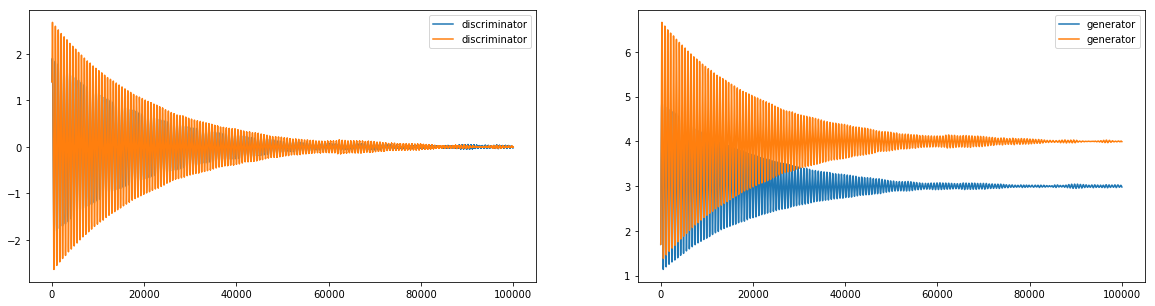

Recovered mean from generator: [ 3.00148416  4.00143388]
Last mean from generator: [ 2.98238711  3.99519445]


In [76]:
# Optimistic SGD Training on Sampled Loss with minibatching=2000
T = 100000
minibatch = 2000
eta_D = .01
eta_G = .01
w = 1.4*np.ones((T, dim))
theta = 1.7*np.ones((T, dim))
xs = np.random.multivariate_normal(mean=v, 
                                   cov = np.eye(dim), 
                                   size=(T, minibatch))
zs = np.random.multivariate_normal(mean=np.zeros(dim), 
                                   cov = np.eye(dim), 
                                   size=(T, minibatch))

bxs = np.mean(xs, axis=1)
bzs = np.mean(zs, axis=1)

for t in range(2,T):
    w[t] = w[t-1] + 2 * eta_D * (bxs[t-1] - bzs[t-1] - theta[t-1])\
            - eta_D * (bxs[t-2] - bzs[t-2] - theta[t-2])
    theta[t] = theta[t-1] + 2 * eta_G * w[t-1] - eta_G * w[t-2]

plot_weights(w, theta)

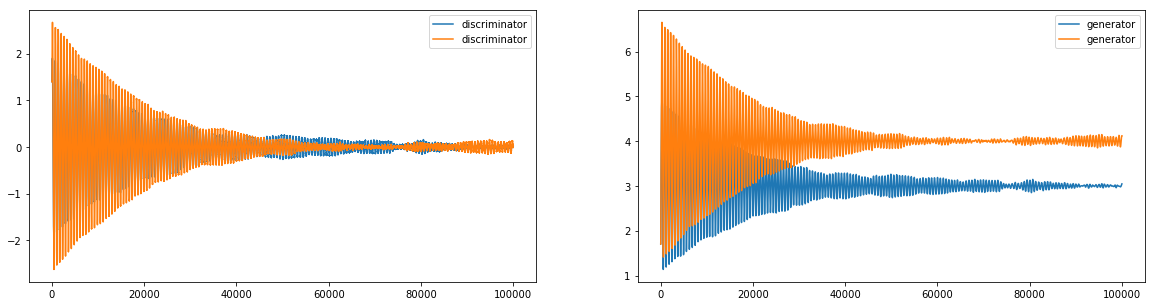

Recovered mean from generator: [ 3.00167037  4.00179954]
Last mean from generator: [ 3.0460187   4.12071012]


In [51]:
# Optimistic SGD Training on Sampled Loss with minibatching=200
T = 100000
minibatch = 200
eta_D = .01
eta_G = .01
w = 1.4*np.ones((T, dim))
theta = 1.7*np.ones((T, dim))
xs = np.random.multivariate_normal(mean=v,
                                   cov = np.eye(dim),
                                   size=(T, minibatch))
zs = np.random.multivariate_normal(mean=np.zeros(dim),
                                   cov = np.eye(dim),
                                   size=(T, minibatch))

bxs = np.mean(xs, axis=1)
bzs = np.mean(zs, axis=1)

for t in range(2,T):
    w[t] = w[t-1] + 2 * eta_D * (bxs[t-1] - bzs[t-1] - theta[t-1])\
            - eta_D * (bxs[t-2] - bzs[t-2] - theta[t-2])
    theta[t] = theta[t-1] + 2 * eta_G * w[t-1] - eta_G * w[t-2]

plot_weights(w, theta)

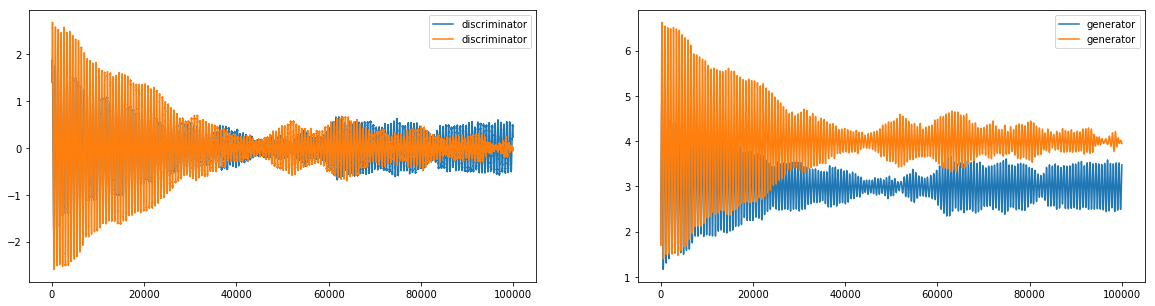

Recovered mean from generator: [ 3.00084304  4.00097096]
Last mean from generator: [ 3.48185447  3.94795707]


In [52]:
# Optimistic SGD Training on Sampled Loss with minibatching=20
T = 100000
minibatch = 20
eta_D = .01
eta_G = .01
w = 1.4*np.ones((T, dim))
theta = 1.7*np.ones((T, dim))
xs = np.random.multivariate_normal(mean=v,
                                   cov = np.eye(dim),
                                   size=(T, minibatch))
zs = np.random.multivariate_normal(mean=np.zeros(dim),
                                   cov = np.eye(dim),
                                   size=(T, minibatch))

bxs = np.mean(xs, axis=1)
bzs = np.mean(zs, axis=1)

for t in range(2,T):
    w[t] = w[t-1] + 2 * eta_D * (bxs[t-1] - bzs[t-1] - theta[t-1])\
            - eta_D * (bxs[t-2] - bzs[t-2] - theta[t-2])
    theta[t] = theta[t-1] + 2 * eta_G * w[t-1] - eta_G * w[t-2]

plot_weights(w, theta)

# Learning a Co-Variance Matrix

Now we consider the case where the data distribution is a mean zero normal with an unknown co-variance matrix, i.e.,
\begin{equation}
x \sim N(0, \Sigma)
\end{equation}

We will consider the case where the discriminator is the set of all quadratic functions:
\begin{equation}
D(x; W_D) = \sum_{ij} W_D^{ij} x_i x_j = x^T W_D x 
\end{equation}
The generator is a linear function of the random input noise $z\sim N(0, I)$, of the form:
\begin{equation}
G(z; V_G) = V_G z
\end{equation}
Hence, now parameters $W_D$ and $V_G$ are both $d\times d$ matrices.

The WGAN associated with these functions is then:
\begin{equation}
\inf_{v_G} \sup_{w_D} \mathbb{E}_{x\sim N(0, \Sigma)}\left[ x^T W_D x \right] - \mathbb{E}_{z\sim N(0,I)}\left[z^T V_G^T W_D V_G z \right] 
\end{equation}
Expanding the latter we get:
\begin{align}
& \inf_{v_G} \sup_{w_D} \mathbb{E}_{x\sim N(0, \Sigma)}\left[ \sum_{ij} W_{ij} x_i x_j \right] - \mathbb{E}_{z\sim N(0,I)}\left[ \sum_{ij} W_{ij} \sum_{k} V_{ik} z_k  \sum_{m} V_{jm} z_m\right] \\
=&
\inf_{v_G} \sup_{w_D} \mathbb{E}_{x\sim N(0, \Sigma)}\left[ \sum_{ij} W_{ij} x_i x_j \right] - \mathbb{E}_{z\sim N(0,I)}\left[ \sum_{ijkm} W_{ij} V_{ik} V_{jm} z_k z_m \right]\\
=& \inf_{v_G} \sup_{w_D} \sum_{ij} W_{ij} \mathbb{E}_{x\sim N(0, \Sigma)}\left[ x_i x_j \right] - \sum_{ijkm} W_{ij} V_{ik} V_{jm} \mathbb{E}_{z\sim N(0,I)}\left[ z_k z_m \right]\\
=& \inf_{v_G} \sup_{w_D} \sum_{ij} W_{ij} \Sigma_{ij} - \sum_{ijkm} W_{ij} V_{ik} V_{jm} 1\{k=m\}\\
=& \inf_{v_G} \sup_{w_D} \sum_{ij} W_{ij} \Sigma_{ij} - \sum_{ijk} W_{ij} V_{ik} V_{jk}\\
=& \inf_{v_G} \sup_{w_D} \sum_{ij} W_{ij} \left(\Sigma_{ij} - \sum_{k} V_{ik} V_{jk}\right)
\end{align}
Given that the covariance matrix is symmetric positive definite, we can write it as $\Sigma = U U^T$. Then the latter is:
\begin{align}
\inf_{v_G} \sup_{w_D} \sum_{ij} W_{ij} \left(\Sigma_{ij} - \sum_{k} V_{ik} V_{jk}\right) =& \inf_{v_G} \sup_{w_D} \sum_{ijk} W_{ij} \left(U_{ik} U_{jk} -  V_{ik} V_{jk}\right)
\end{align}
The equilibrium of this game is for the generator to choose $V_{ik} = U_{ik}$ for all $i,k$, and for the discriminator to pick $W_{ij}=0$.

As a sanity check: In the case of a single dimension then we have:
\begin{align}
D(x; W_D) =& W_D \cdot x^2\\
G(z; V_G) =& V_G \cdot z
\end{align}
Then we have:
\begin{equation}
\inf_{v_G} \sup_{w_D} \mathbb{E}_{x\sim N(0, \sigma^2)}\left[ W_D \cdot x^2 \right] - \mathbb{E}_{z\sim N(0,1)}\left[W_D \cdot V_G^2 \cdot z^2 \right] = \inf_{v_G} \sup_{w_D} W_D \cdot(\sigma^2 - V_G^2) 
\end{equation}



[[-1.57890256]]
[[ 2.49293329]]


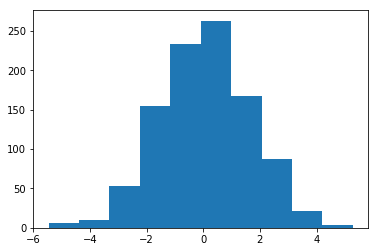

In [77]:
# Parameters of distribution
dim = 1
U = np.random.normal(size=(dim,dim)) + 0.1
print(U)
Sigma = np.dot(U, U.T)
print(Sigma)
x = np.random.multivariate_normal(mean = np.zeros(dim),
                                  cov = Sigma, size=1000)
if dim == 2:
    plt.scatter(x[:,0], x[:,1])
if dim == 1:
    plt.hist(x)
plt.show()

## Without Sampling Noise

For the mean GD dynamics the update rules are as follows:
\begin{align}
W_{ij}^t =& W_{ij}^{t-1} + \eta_D \left(\Sigma_{ij} - \sum_{k} V_{ik}^{t-1} V_{jk}^{t-1}\right) \\
V_{ij}^t =& V_{ij}^{t-1} + \eta_G \sum_{k} \left(W_{ik}^{t-1} + W_{ki}^{t-1}\right) V_{kj}^{t-1} 
\end{align}
We can write the latter updates more simply in matrix former:
\begin{align}
W_t =& W_{t-1} + \eta_D \left(\Sigma - V_{t-1} V_{t-1}^T\right)\\
V_t =& V_{t-1} + \eta_G (W_{t-1} + W_{t-1}^T) V_{t-1}^T
\end{align}

As a sanity check in the case of a single dimension the latter is:
\begin{align}
W_t =& W_{t-1} + \eta_D \left(\sigma^2 - V_{t-1}^2\right)\\
V_t =& V_{t-1} + \eta_G 2 W_{t-1} V_{t-1}
\end{align}


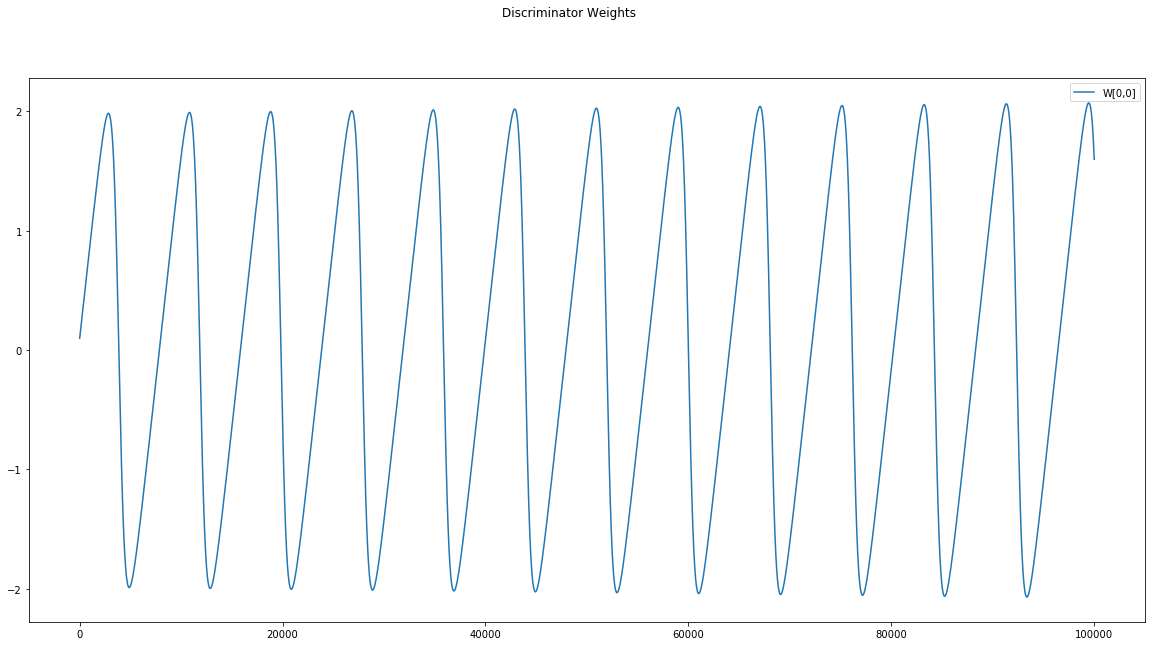

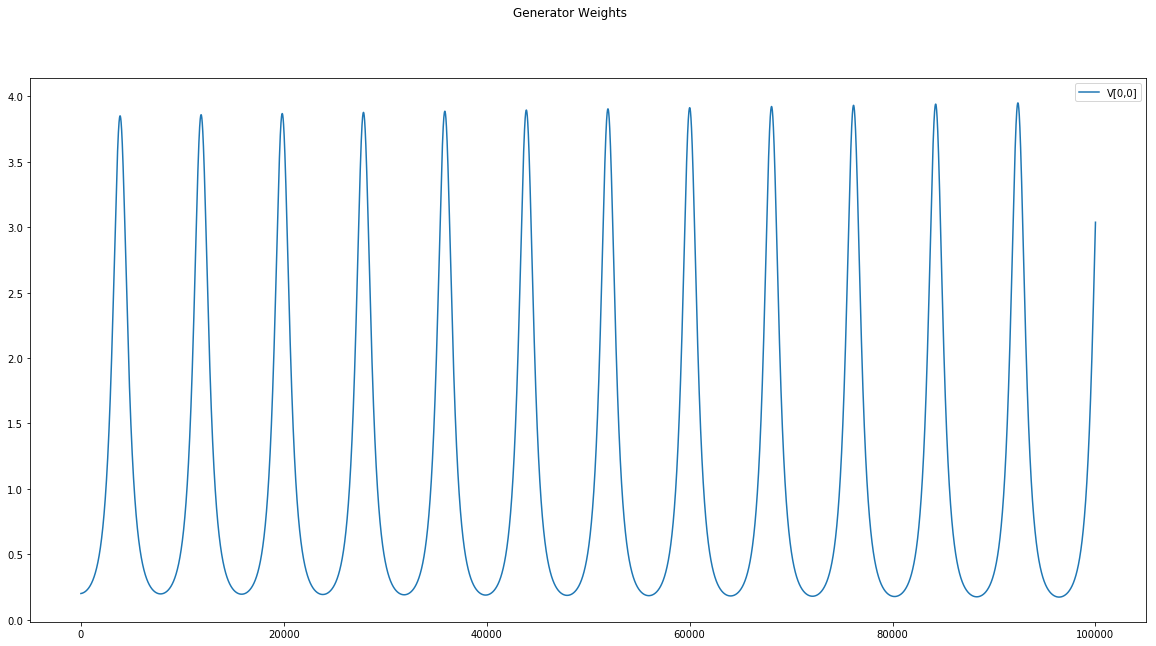

Last Iteration Sigma:[[ 9.23219343]]
Average Sigma: [[ 1.1543928]]
True Sigma: [[ 2.49293329]]


In [80]:
# GD Training on the expected loss
T = 100000
clip_D = 10
clip_G = 10
eta_D = 0.1/(dim*np.sqrt(T))
eta_G = 0.1/(dim*np.sqrt(T))
train_gen_every = 1
w_D = .1*np.ones((T, dim, dim))
v_G = .2*np.ones((T, dim, dim))

for t in range(1,T):
    w_D[t] = np.clip(w_D[t-1]\
                     + eta_D * (Sigma - np.dot(v_G[t-1], v_G[t-1].T)),
                     -clip_D, clip_D)
    if t%train_gen_every==0:
        v_G[t] = np.clip(v_G[t-1]\
                         + eta_G * np.dot(w_D[t-1] + w_D[t-1].T, v_G[t-1].T),
                         -clip_D, clip_D) 
    else:
        v_G[t] = v_G[t-1]

plt.figure(figsize=(20, 10))
plt.suptitle("Discriminator Weights")
for i in range(dim):
    for j in range(dim):
        plt.subplot(dim, dim, i*dim+j+1)
        plt.plot(w_D[:, i, j], label="W[{},{}]".format(i, j))
        plt.legend()
plt.show()

plt.figure(figsize=(20, 10))
plt.suptitle("Generator Weights")
for i in range(dim):
    for j in range(dim):
        plt.subplot(dim, dim, i*dim+j+1)
        plt.plot(v_G[:, i, j], label="V[{},{}]".format(i, j))
        plt.legend()
plt.show()

print("Last Iteration Sigma:{}".format(np.dot(v_G[-1], v_G[-1].T)))
print("Average Sigma: {}"
      .format(np.dot(np.mean(v_G, axis=0), np.mean(v_G, axis=0).T)))
print("True Sigma: {}".format(Sigma))

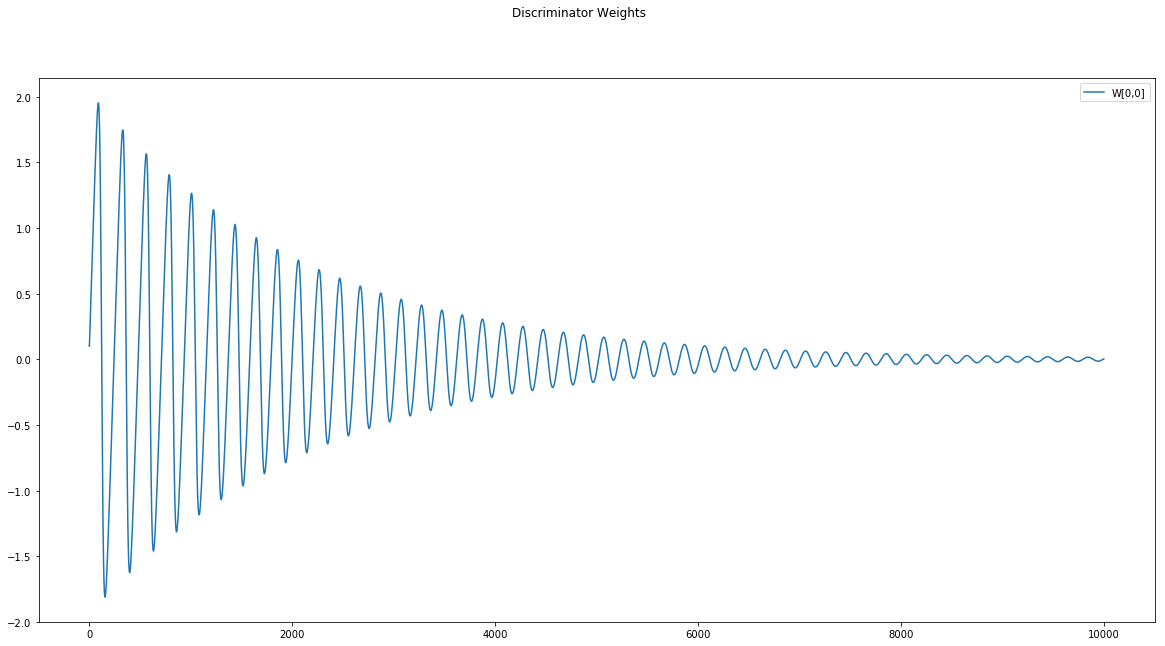

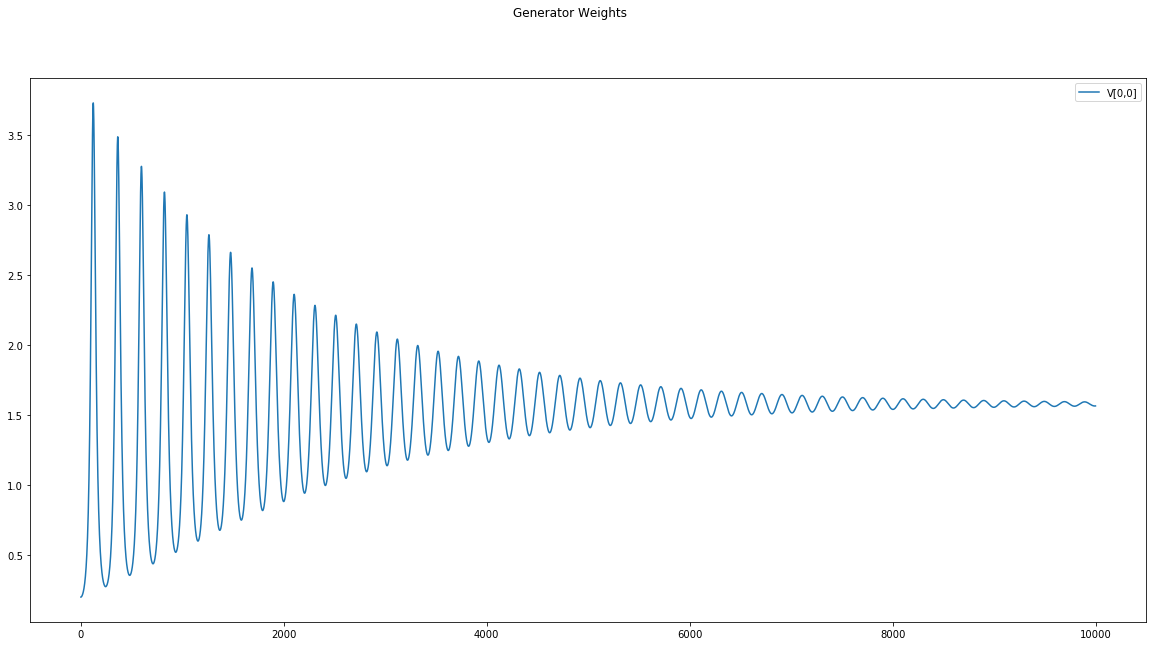

Last Iteration Sigma:[[ 2.44904256]]
True Sigma: [[ 2.49293329]]


In [87]:
# Optimistic GD Training on the expected loss
T = 10000
clip_D = 10
clip_G = 10
eta_D = 0.01
eta_G = 0.01
w_D = .1*np.ones((T, dim, dim))
v_G = .2*np.ones((T, dim, dim))

for t in range(2,T):
    w_D[t] = w_D[t-1] + 2 * eta_D * (Sigma - np.dot(v_G[t-1], v_G[t-1].T))\
                - eta_D * (Sigma - np.dot(v_G[t-2], v_G[t-2].T))
    v_G[t] = v_G[t-1] + 2 * eta_G * np.dot(w_D[t-1] + w_D[t-1].T, v_G[t-1].T)\
                - eta_G * np.dot(w_D[t-2] + w_D[t-2].T, v_G[t-2].T) 
    
plt.figure(figsize=(20, 10))
plt.suptitle("Discriminator Weights")
for i in range(dim):
    for j in range(dim):
        plt.subplot(dim, dim, i*dim+j+1)
        plt.plot(w_D[:, i, j], label="W[{},{}]".format(i, j))
        plt.legend()
plt.show()

plt.figure(figsize=(20, 10))
plt.suptitle("Generator Weights")
for i in range(dim):
    for j in range(dim):
        plt.subplot(dim, dim, i*dim+j+1)
        plt.plot(v_G[:, i, j], label="V[{},{}]".format(i, j))
        plt.legend()
plt.show()

print("Last Iteration Sigma:{}".format(np.dot(v_G[-1], v_G[-1].T)))
print("True Sigma: {}".format(Sigma))